In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
##Add decomposed components: PCA / ICA etc.
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedKFold, KFold
import matplotlib.pyplot as plt

## 1. Load

In [2]:
# load data
train = pd.read_csv("../../data/Mercedes_Benz_Greener_Manufacturing/raw/train.csv")
test = pd.read_csv("../../data/Mercedes_Benz_Greener_Manufacturing/raw/test.csv")

In [3]:
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print(train.shape, test.shape)

(4209, 378) (4209, 377)


## 3. Encode

In [5]:
cols_cat = train.select_dtypes(include = ['object']).columns.values

In [6]:
dt_cat_train_y = train[cols_cat].join(train.y)
dt_cat_test = train[cols_cat].join(train.y)

In [7]:
for c in cols_cat:
    x = list(set(list(train[c].values) + list(test[c].values))) 
    x.sort()
    x.sort(key = len)
    dt_labelEncode_c = pd.DataFrame({"Encode_" + c: [i for i in range(1, (len(x) + 1))]
                                     , c: x})

    train = pd.merge(train, dt_labelEncode_c, on = c)
    test = pd.merge(test, dt_labelEncode_c, on = c)

In [8]:
train = train.drop(cols_cat, axis = 1)
test = test.drop(cols_cat, axis = 1)

In [9]:
train.iloc[:5, 0:20]

,ID,y,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28
0,0,130.81,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
1,5761,115.07,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,5883,77.38,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,4275,111.21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
4,7348,103.70,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


## 3. Decomposition

In [10]:
n_comp = 12

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
tsvd_results_train = tsvd.fit_transform(train.drop(["y"], axis=1))
tsvd_results_test = tsvd.transform(test)

# PCA
pca = PCA(n_components=n_comp, random_state=420)
pca2_results_train = pca.fit_transform(train.drop(["y"], axis=1))
pca2_results_test = pca.transform(test)

# ICA
ica = FastICA(n_components=n_comp, random_state=420)
ica2_results_train = ica.fit_transform(train.drop(["y"], axis=1))
ica2_results_test = ica.transform(test)

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
grp_results_train = grp.fit_transform(train.drop(["y"], axis=1))
grp_results_test = grp.transform(test)

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=420)
srp_results_train = srp.fit_transform(train.drop(["y"], axis=1))
srp_results_test = srp.transform(test)

In [11]:
#save columns list before adding the decomposition components

usable_columns = list(set(train.columns) - set(['y']))

# Append decomposition components to datasets
for i in range(1, n_comp + 1):
    train['pca_' + str(i)] = pca2_results_train[:, i - 1]
    test['pca_' + str(i)] = pca2_results_test[:, i - 1]

    train['ica_' + str(i)] = ica2_results_train[:, i - 1]
    test['ica_' + str(i)] = ica2_results_test[:, i - 1]

    train['tsvd_' + str(i)] = tsvd_results_train[:, i - 1]
    test['tsvd_' + str(i)] = tsvd_results_test[:, i - 1]

    train['grp_' + str(i)] = grp_results_train[:, i - 1]
    test['grp_' + str(i)] = grp_results_test[:, i - 1]

    train['srp_' + str(i)] = srp_results_train[:, i - 1]
    test['srp_' + str(i)] = srp_results_test[:, i - 1]


In [12]:
train.shape

(4209, 438)

## 4. Feature Engineer

In [13]:
# oof to encode cols_cat with TargetMean
def getTargetMean(dt, dt_all, cols, k = 3):

    # init dt_targetMean
    dt_targetMean = pd.DataFrame()

    for col in cols:
    
        # init dt_targetMean_oof
        dt_targetMean_oof = pd.DataFrame()
        
        # X_targetMean_Kfold, y_targetMean_Kfold
        X_targetMean_Kfold = dt[[col, "y"]]
        y_targetMean_Kfold = dt[col].values

        # oof cv
#         skf = StratifiedKFold(n_splits = k)
        kf = KFold(n_splits = k)
        
        
#         for i, (ind_in, ind_out) in enumerate(skf.split(X_targetMean_Kfold, y_targetMean_Kfold)):
        for i, (ind_in, ind_out) in enumerate(kf.split(X_targetMean_Kfold)):

            # init dt_targetMean_oof
            dt_targetMean_val = pd.DataFrame()

            # X_in, X_out, y_in, y_out
            X_in, X_out = X_targetMean_Kfold.iloc[ind_in], X_targetMean_Kfold.iloc[ind_out]
            y_in, y_out = y_targetMean_Kfold[ind_in], y_targetMean_Kfold[ind_out]

            # calc TargetMean
            for val in set(X_in[col].values):
                dt_targetMean_temp = pd.DataFrame({"Value": [val]
                                                   , "TargetMean_" + str(i): [X_in.loc[X_in[col] == val].y.mean()]})
                dt_targetMean_val = pd.concat([dt_targetMean_val, dt_targetMean_temp])

            # merge with oof
            if i == 0:
                dt_targetMean_oof = pd.merge(X_targetMean_Kfold.drop("y", axis = 1).drop_duplicates(), dt_targetMean_val
                                             , how = "left", left_on = col, right_on = "Value")
                dt_targetMean_oof = dt_targetMean_oof.drop(col, axis = 1)
            else:
                dt_targetMean_oof = pd.merge(dt_targetMean_oof, dt_targetMean_val
                                             , how = "left", on = "Value")

        # move Value to the first column
        value = dt_targetMean_oof['Value']
        dt_targetMean_oof.drop(labels = ["Value"], axis = 1,inplace = True)
        dt_targetMean_oof.insert(0, 'Value', value)
        # assign col
        dt_targetMean_oof.insert(0, 'Col', col)
        
        # concat with col
        dt_targetMean = pd.concat([dt_targetMean, dt_targetMean_oof])
    
    # mean of oof
    dt_targetMean["TargetMean"] = dt_targetMean.filter(regex = "TargetMean").mean(axis = 1)
    # fill zero
    dt_targetMean = dt_targetMean.fillna(0)
    # remove oof cols
    dt_targetMean = dt_targetMean[["Col", "Value", "TargetMean"]]

    # merge to original table
    dt_cat_cols = dt_all[cols]
    
    for col in cols_cat:
        dt_cat_cols = pd.merge(dt_cat_cols, dt_targetMean.loc[dt_targetMean["Col"] == col]
                           , how = "left", left_on = col, right_on = "Value")
        dt_cat_cols = dt_cat_cols.drop(["Value", "Col"], axis = 1)
        dt_cat_cols = dt_cat_cols.rename(columns = {"TargetMean": "Encode_TargetMean_" + col})
    # fill zero
    dt_cat_cols = dt_cat_cols.fillna(0)
    
    # only select targetMean cols
    dt_cat_targetMean = dt_cat_cols.filter(regex = "Encode_TargetMean_")
        
    return dt_cat_targetMean

In [14]:
## remove the outlier and tm
dt_cat_targetMean_train = getTargetMean(dt_cat_train_y
                                  , train.join(dt_cat_train_y[cols_cat])
                                  , cols_cat
                                  , 5)
dt_cat_targetMean_test = getTargetMean(dt_cat_train_y
                                  , test.join(dt_cat_test[cols_cat])
                                  , cols_cat
                                  , 5)

In [15]:
dt_cat_targetMean_train.head()

,Encode_TargetMean_X0,Encode_TargetMean_X1,Encode_TargetMean_X2,Encode_TargetMean_X3,Encode_TargetMean_X4,Encode_TargetMean_X5,Encode_TargetMean_X6,Encode_TargetMean_X8
0,99.573794,101.410135,105.899133,102.470110,100.658327,0.0,101.165622,97.738131
1,99.573794,93.742023,95.873333,100.037380,100.658327,0.0,98.943528,97.738131
2,78.019894,95.781197,83.367776,101.956493,100.658327,0.0,101.165622,98.598047
3,78.019894,93.742023,83.367776,96.568490,100.658327,0.0,98.943528,104.995109
4,78.019894,101.410135,83.367776,96.568490,100.658327,0.0,101.349220,102.194921


In [16]:
dt_cat_train_y.head()

,X0,X1,X2,X3,X4,X5,X6,X8,y
0,k,v,at,a,d,u,j,o,130.81
1,k,t,av,e,d,y,l,o,88.53
2,az,w,n,c,d,x,j,x,76.26
3,az,t,n,f,d,x,l,e,80.62
4,az,v,n,f,d,h,d,n,78.02


In [17]:
train = train.join(dt_cat_targetMean_train)
test = test.join(dt_cat_targetMean_test)

In [18]:
train.shape

(4209, 446)

In [19]:
# for c in cols_cat:
#     dt_targetMean_c = pd.DataFrame({c: dt_cat_train_y.groupby(c)["y"].mean().index
#              , "TargetMean_" + c: dt_cat_train_y.groupby(c)["y"].mean().values})
#     dt_cat_train_y = pd.merge(dt_cat_train_y, dt_targetMean_c, on = c)
#     dt_cat_test = pd.merge(dt_cat_test, dt_targetMean_c, on = c)

# dt_cat_train_y.head()

# dt_cat_test.head()

# train = train.join(dt_cat_train_y.filter(regex = "TargetMean"))
# test = test.join(dt_cat_test.filter(regex = "TargetMean"))

# train.shape

# test.shape

## 5. xgboost

In [20]:
# r_2 for xgboost
def r_2(preds, dtrain):
    labels = dtrain.get_label()
    return 'score', r2_score(labels, preds)

In [21]:
y_train = train['y'].values
y_mean = np.mean(y_train)

In [22]:
params_xgb = {
    'n_trees': 520,
    'eta': 0.0045,
    'max_depth': 4,
    'subsample': 0.98,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean, # base prediction = mean(target)
    'silent': 1
}

In [23]:
# xgbDmatrix
dtrain = xgb.DMatrix(train.drop('y', axis=1), y_train)
dtest = xgb.DMatrix(test)

In [24]:
# cv
cv_xgb = xgb.cv(params_xgb, dtrain
                , num_boost_round = 5000
                , nfold = 10
                , feval = r_2, maximize = True, early_stopping_rounds = 50
                , show_stdv = True, verbose_eval = 50, seed = 888)

[0]	train-rmse:12.6446+0.108585	train-score:0.0051812+8.09973e-05	test-rmse:12.6109+0.936524	test-score:0.0033585+0.00127191
[50]	train-rmse:11.2339+0.11494	train-score:0.214789+0.00301734	test-rmse:11.2309+1	test-score:0.210991+0.0250388
[100]	train-rmse:10.2217+0.121739	train-score:0.349926+0.00491699	test-rmse:10.2551+1.06202	test-score:0.342963+0.0408737
[150]	train-rmse:9.50835+0.128116	train-score:0.437497+0.00613659	test-rmse:9.58238+1.11314	test-score:0.42673+0.0507992
[200]	train-rmse:9.01286+0.133781	train-score:0.494597+0.0069625	test-rmse:9.12889+1.15371	test-score:0.479838+0.0572982
[250]	train-rmse:8.67201+0.137744	train-score:0.5321+0.00746315	test-rmse:8.82697+1.18305	test-score:0.513679+0.0614267
[300]	train-rmse:8.43651+0.140221	train-score:0.557168+0.00774172	test-rmse:8.63061+1.20286	test-score:0.535027+0.0640382
[350]	train-rmse:8.27077+0.142331	train-score:0.574395+0.00796327	test-rmse:8.50387+1.21533	test-score:0.548523+0.0656698
[400]	train-rmse:8.1489+0.143389	

In [25]:
# train
model_xgb = xgb.train(params_xgb, dtrain, num_boost_round = cv_xgb.shape[0])

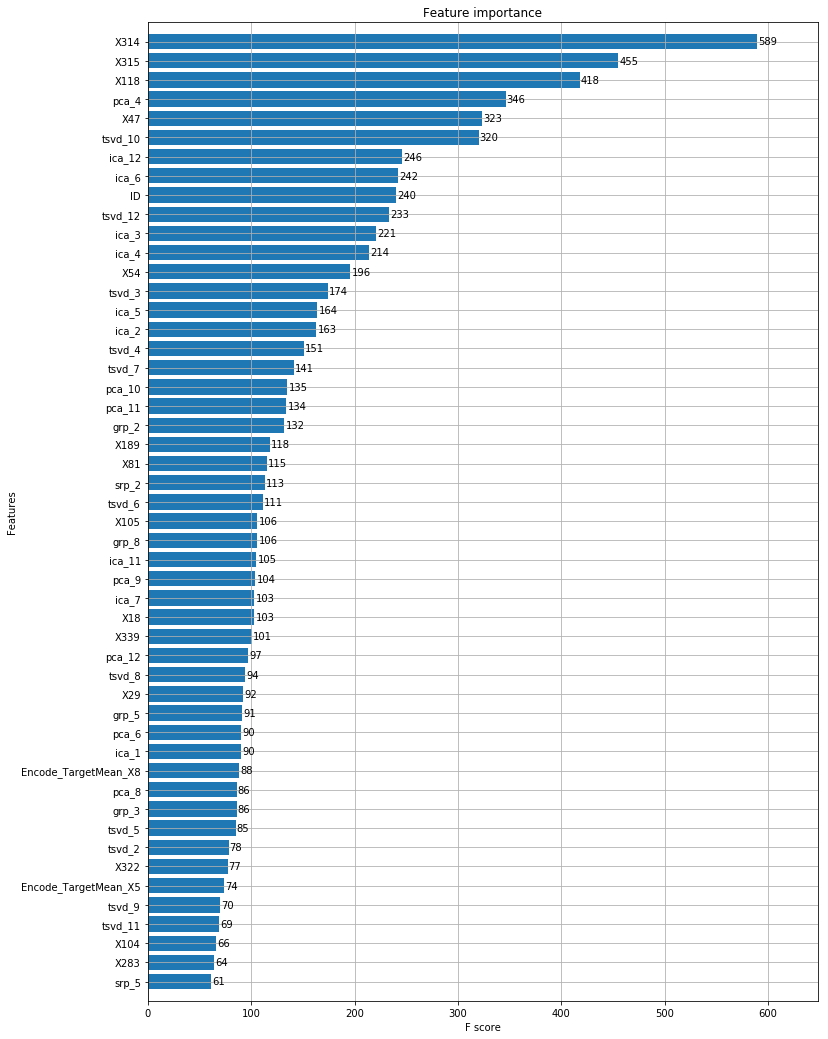

In [26]:
# importance
fig, ax = plt.subplots(figsize = (12,18))
xgb.plot_importance(model_xgb, max_num_features = 50, height = 0.8, ax = ax)
plt.show()